In [ ]:
import queue
import numpy as np
import tensorflow as tf
import tf_agents as tfa
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import nest_utils

In [ ]:
class TenArmedTestbed(
    tfa.bandits.environments.bandit_py_environment.BanditPyEnvironment):

    def __init__(self):
        observation_spec = tfa.specs.array_spec.BoundedArraySpec(
            shape=(10,), dtype=np.float32, minimum=-4, maximum=4, name='observation')
        action_spec = tfa.specs.array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=9, name='action')

        self._action_values = np.random.normal(size=(10,))
        
        super(TenArmedTestbed, self).__init__(observation_spec=observation_spec,
                                              action_spec=action_spec)
    
    def _observe(self):
        self._observation = np.random.normal(loc=self._action_values, size=(10,))
        return self._observation

    def _apply_action(self, action):
        return self._observation[action]

In [ ]:
class GreedyPolicy(tfa.policies.py_policy.PyPolicy):
    
    def __init__(self, action_values):
        observation_spec = tfa.specs.array_spec.BoundedArraySpec(
            shape=(10,), dtype=np.float32, minimum=-4, maximum=4, name='observation')
        action_spec = tfa.specs.array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=9, name='action')
        time_step_spec = ts.time_step_spec(observation_spec)
        
        self._action_values = action_values

        super(GreedyPolicy, self).__init__(time_step_spec=time_step_spec,
                                           action_spec=action_spec)
    
    def _action(self, time_step, policy_state):
        action = np.argmax(self._action_values)
        return tfa.trajectories.policy_step.PolicyStep(action, policy_state)

In [ ]:
class EpsilonGreedyPolicy(tfa.policies.py_policy.PyPolicy):
    
    def __init__(self, action_values, epsilon):
        observation_spec = tfa.specs.array_spec.BoundedArraySpec(
            shape=(10,), dtype=np.float32, minimum=-4, maximum=4, name='observation')
        action_spec = tfa.specs.array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=9, name='action')
        time_step_spec = ts.time_step_spec(observation_spec)
        
        self._epsilon = epsilon
        self._action_values = action_values

        super(EpsilonGreedyPolicy, self).__init__(time_step_spec=time_step_spec,
                                                  action_spec=action_spec)
    
    def _action(self, time_step, policy_state):
        
        if np.random.uniform([1], maxval=1) < self._epsilon:
            action = np.random.uniform([1], maxval=10, dtype=np.int32)
        else:
            action = np.argmax(self._action_values)
        
        return tfa.trajectories.policy_step.PolicyStep(action, policy_state)

In [ ]:
class UCBPolicy(tfa.policies.py_policy.PyPolicy):
    
    def __init__(self, action_values, c, num_steps, num_samples):
        observation_spec = tfa.specs.array_spec.BoundedArraySpec(
            shape=(10,), dtype=np.float32, minimum=-4, maximum=4, name='observation')
        action_spec = tfa.specs.array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=9, name='action')
        time_step_spec = ts.time_step_spec(observation_spec)
        
        self._action_values = action_values
        self._c = c
        self._num_steps = num_steps
        self._num_samples = num_samples

        super(UCBPolicy, self).__init__(time_step_spec=time_step_spec,
                                        action_spec=action_spec)
    
    def _action(self, time_step, policy_state):
        
        action = np.argmax(self._action_values + self._c * np.sqrt(np.log(self._num_steps)/self._num_samples))
        
        return tfa.trajectories.policy_step.PolicyStep(action, policy_state)

In [ ]:
class BanditAgent(tfa.agents.tf_agent.TFAgent):
    
    def __init__(self,
                 init=tf.zeros(10),
                 alpha=0.1,
                 epsilon=0.1,
                 c=2,
                 policy="Greedy",
                 update_type="sample_average"):
          
        self._update_type = tf.constant(update_type, dtype=tf.string)
        self._alpha = tf.constant(alpha, tf.float32)
        self._action_values = tf.Variable(init, dtype=tf.float32)
        self._num_steps = tf.Variable(0, dtype=tf.int32)
        self._num_samples = tf.Variable(tf.zeros(10), dtype=tf.float32)
        
        cases = [(tf.equal(policy, "Greedy"), lambda: GreedyPolicy(self._action_values)),
                 (tf.equal(policy, "EpsilonGreedy"), lambda: EpsilonGreedyPolicy(self._action_values, epsilon)),
                 (tf.equal(policy, "UCB"), lambda: UCBPolicy(self._action_values, c, self._num_steps, self._num_samples))]
        policy = tf.case(cases, exclusive=True)
        
        time_step_spec = policy.time_step_spec
        action_spec = policy.action_spec
        
        super(BanditAgent, self).__init__(time_step_spec=time_step_spec,
                                          action_spec=action_spec,
                                          policy=policy,
                                          collect_policy=policy,
                                          train_sequence_length=None)
        
    @property
    def action_values(self):
        return self._action_values
    
    @property
    def num_samples(self):
        return self._num_samples
    
    def _sample_average_update(self, action, reward):
        return 1/self._num_samples[tf.squeeze(action)] * \
               (reward - self._action_values[tf.squeeze(action)])
    
    def _alpha_update(self, action, reward):
        return self._alpha * \
               (reward - self._action_values[tf.squeeze(action)])
    
    def _train(self, experience, weights=None):
        observation = experience.observation
        action = experience.action
        reward = experience.reward
        
        self._num_steps.assign_add(1)
         
        self._num_samples.assign(
            tf.tensor_scatter_nd_add(
                self._num_samples,
                action,
                [1]))
        
        action_value_update = tf.squeeze(
            tf.cond(
                tf.equal(self._update_type, "sample_average"),
                lambda: self._sample_average_update(action, reward),
                lambda: self._alpha_update(action, reward)))
        
        self._action_values.assign(
            tf.tensor_scatter_nd_add(
                self._action_values,
                action,
                [action_value_update]))

        return tfa.agents.tf_agent.LossInfo((), ())

In [ ]:
def train_bandit(agent, env, num_iterations, metrics):
    replay_buffer = tfa.replay_buffers.py_uniform_replay_buffer.PyUniformReplayBuffer(
        tfa.specs.tensor_spec.to_nest_array_spec(agent.collect_data_spec), capacity=1)

    rb_observer = lambda x: replay_buffer.add_batch(tfa.utils.nest_utils.batch_nested_array(x))
    observers = [rb_observer] + metrics

    driver = tfa.drivers.py_driver.PyDriver(env, agent.policy, observers, max_steps=1)
    initial_time_step = env.reset()
    for _ in range(num_iterations):
        driver.run(initial_time_step)
        agent.train(replay_buffer.gather_all())
        replay_buffer.clear()

In [ ]:
num_iterations = 1000

agent = BanditAgent()
env = TenArmedTestbed()
metrics = [tfa.metrics.py_metrics.AverageReturnMetric(buffer_size=num_iterations)]

train_bandit(agent, env, num_iterations, metrics)

In [ ]:
agent = BanditAgent()
environment = TenArmedTestbed()
tf_environment = tfa.environments.tf_py_environment.TFPyEnvironment(environment)

history = compute_average_reward(agent, tf_environment, 1000, 1)

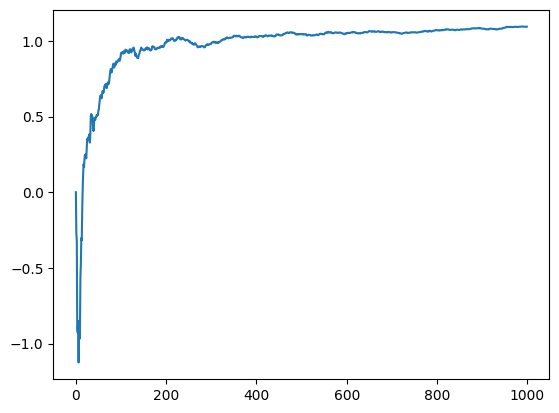

In [ ]:
plt.plot(history)
plt.show()

In [ ]:
runs = 10
niter = 1000

agent = BanditAgent()
environment = TenArmedTestbed()
tf_environment = tfa.environments.tf_py_environment.TFPyEnvironment(environment)

start = timer()
driver(agent, tf_environment, niter, runs)
end = timer()
print((end - start)/runs)

5.37727477100002


In [ ]:
environment = TenArmedTestbed()
tf_environment = tfa.environments.tf_py_environment.TFPyEnvironment(environment)

epsilon = 0.1
num_iter = 1000
runs = 100

greedy_agent = BanditAgent(num_iter=niter)
egreedy_agent01 = BanditAgent(epsilon=0.1,
                              num_iter=num_iter,
                              policy="EpsilonGreedy")
egreedy_agent001 = BanditAgent(epsilon=0.01,
                               num_iter=num_iter,
                               policy="EpsilonGreedy")

greedy_history = compute_average_reward(greedy_agent, tf_environment, num_iter, runs)
egreedy01_history = compute_average_reward(egreedy_agent01, tf_environment, num_iter, runs)
egreedy001_history = compute_average_reward(egreedy_agent001, tf_environment, num_iter, runs)

KeyboardInterrupt: 

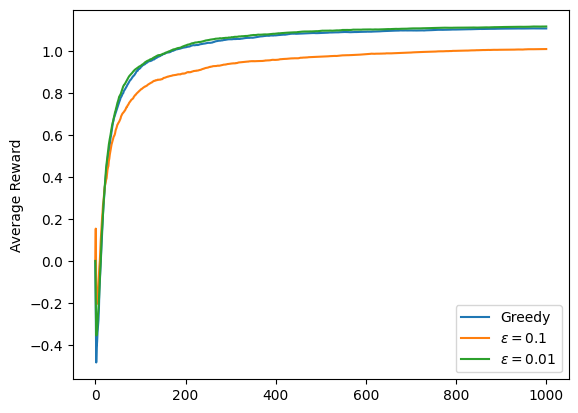

In [ ]:
plt.plot(greedy_history, label="Greedy")
plt.plot(egreedy01_history, label="$\epsilon=0.1$")
plt.plot(egreedy001_history, label="$\epsilon=0.01$")
plt.legend()
plt.ylabel("Average Reward")
plt.show()

In [ ]:
environment = TenArmedTestbed()
tf_environment = tfa.environments.tf_py_environment.TFPyEnvironment(environment)

epsilon = 0.1
niter = 1000
runs = 100
init = np.ones(10) * 5
step_size = 0.1

optimistic_greedy_agent = BanditAgent(0.1, niter, init, "Greedy", step_size)
optimistic_greedy_history = compute_average_reward(optimistic_greedy_agent,
                                                   tf_environment,
                                                   niter,
                                                   runs)

realistic_greedy_agent = BanditAgent(epsilon, niter, np.zeros(10), "EpsilonGreedy", step_size)
realistic_greedy_history = compute_average_reward(realistic_greedy_agent,
                                                  tf_environment,
                                                  niter,
                                                  runs)

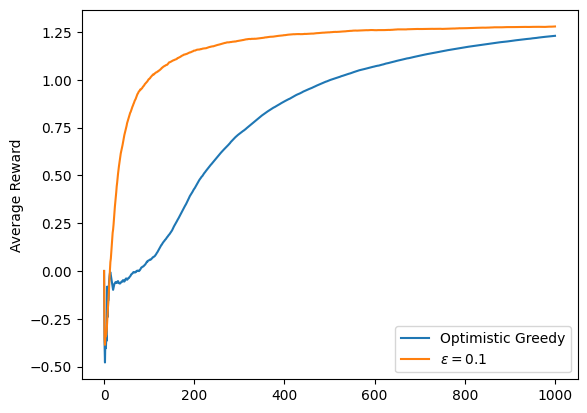

In [ ]:
plt.plot(optimistic_greedy_history, label="Optimistic Greedy")
plt.plot(realistic_greedy_history, label="$\epsilon=0.1$")
plt.legend()
plt.ylabel("Average Reward")
plt.show()

In [ ]:
environment = TenArmedTestbed()
tf_environment = tfa.environments.tf_py_environment.TFPyEnvironment(environment)

epsilon = 0.1
niter = 1000
runs = 100
init = np.zeros(10)
step_size = 0.1

greedy_agent = BanditAgent(0.1, niter, init, "EpsilonGreedy", step_size)
greedy_history = compute_average_reward(greedy_agent,
                                        tf_environment,
                                        niter,
                                        runs)

ucb_agent = BanditAgent(2, niter, init, "UCB", step_size)
ucb_history = compute_average_reward(ucb_agent,
                                     tf_environment,
                                     niter,
                                     runs)

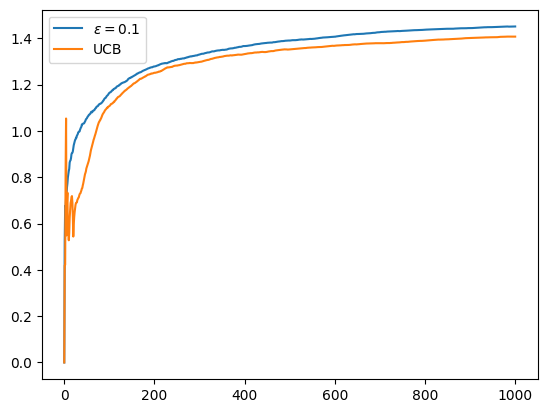

In [ ]:
plt.plot(greedy_history, label="$\epsilon=0.1$")
plt.plot(ucb_history, label="UCB")
plt.legend()
plt.show()